# Keras Model for Beginners (0.210 on LAB)+EDA+R&D

In [1]:
!pip install -U kaleido

     |████████████████████████████████| 79.9 MB 198 kB/s 


In [2]:
# 이 파이썬 3 환경에는 많은 유용한 분석 라이브러리가 설치되어 있음.
# Kaggle / Docker 이미지로 정의됨 : https://github.com/kaggle/docker-python
# 예를 들어, 로드하는데 도움이 되는 패키지가 몇 가지 있음. 

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# 입력 데이터 파일은 "../input" 디렉토리에서 사용할 수 있음 -> 코랩에 구글 드라이브 마운트라 상관 X
# 예를 들어 (실행을 클릭하거나 Shift+Enter를 눌러) 이 작업을 실행하면 입력 디렉토리에 파일이 나열됨.

from subprocess import check_output
print(check_output(["ls", "/content/drive/MyDrive/Colab Notebooks/Kaggle Study/Statoil C-CORE Iceberg Classifier Challenge/data"]).decode("utf8"))

# 현재 디렉토리에 쓴 결과는 출력으로 저장됨.

sample_submission.csv
test.json
train.json



- 이 커널은 특히 Keras를 사용해 CNN을 구축하려는 초보자를 위한 것임.
- 이 커널을 사용하면 좋은 점수를 얻을 수 있을 뿐만 아니라 Keras도 배울 수 있음.
- Keras는 모델을 초기화하고 원하는 레이어를 계속 쌓을 수 있는 단순한 프레임워크임.
- 이것으로 깊은 신경망을 매우 쉽게 만들 수 있음. 

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [4]:
# 데이터 로드
train = pd.read_json("/content/drive/MyDrive/Colab Notebooks/Kaggle Study/Statoil C-CORE Iceberg Classifier Challenge/data/train.json")

In [5]:
test = pd.read_json("/content/drive/MyDrive/Colab Notebooks/Kaggle Study/Statoil C-CORE Iceberg Classifier Challenge/data/test.json")

## 데이터 소개
- Sentinel-1  위성은 지상 약 680km에 있다. 
- 특정 입사 각도로 신호 펄스를 전송하고 다시 부호화함.
- 기본적으로 이러한 반사 신호를 후방 산란이라고 함. 
- 제공된 데이터는 후방 산란 계수이며, 이는 다음과 같은 방식으로 제공되는 기존 후방 산란 계수임.  
$σo(dB)=βo(dB)+10log10[sin(ip)/sin(ic)]$  
1. ip는 특정 픽셀의 입사각
2. ic는 이미지 중심에 대한 입사각
3. K는 상수
- 데이터에는 $σo$가 직접 기재되어 있음.


### $σo$의 특징에 대한 설명
- 기본적으로 신호가 산란되는 면에 따라 $σo$가 달라짐. 예를 들어, 특정 입사 각도의 경우 다음과 같이 변화함.
- WATER........... SETTLEMENTS........ AGRICULTURE........... BARREN........  
1. HH: -27.001 ................ 2.70252 ................. -12.7952 ................ -17.25790909
2. HV: -28.035 ................ -20.2665 .................. -21.4471 ................. -20.019  
- 보다시피 HH 컴포넌트는 많이 다르지만 HV는 그렇지 않음. 
- 선박의 산란 데이터는 없지만 금속 물체이기 때문에 얼음 물체와는 차이가 있을 것임.

### HH랑 HV가 뭐지?
- 이 Sentinel 위성은 RISTSAT(인도 원격감지 위성)에 해당하고, Ping은 H 편파만 전송하고 V 편파에는 전송하지 않음. 이러한 H-핑은 흩어지고, 물체는 편광을 변화시켜 H와 V의 혼합으로 돌아옴. 
- Sentinel에는 H-transmitter만 있기 때문에 리턴 신호는 HH 및 HV 형식 뿐임. VV가 제공되지 않는 이유는 묻지 말라고 함. (Sentinel에는 V-ping 송신기가 없기 때문임)
- 이제 특징에 대해 설명하자면, 이 데모 코드의 목적상, 2개의 대역을 모두 추출해 3번째 채널로 평균을 취해 3채널 RGB에 상당하는 것을 만들고 있음. 

In [6]:
# training 데이터 생성
# Create 3 bands having HH, HV and avg of both
X_band_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train['band_1']])
X_band_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train['band_1']])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis], ((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

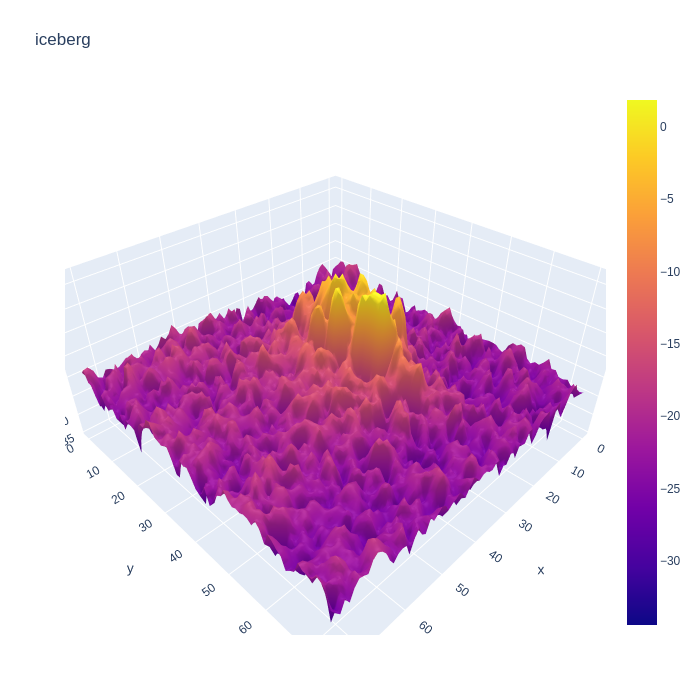

In [7]:
# 빙산 살펴보기
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
def plotmy3d(c, name):
  
  data = [
          go.Surface(
              z=c
          )
  ]
  layout = go.Layout(
      title=name,
      autosize=False,
      width=700,
      height=700,
      margin=dict(
          l=65,
          r=50,
          b=65,
          t=90
      )
  )
  fig = go.Figure(data=data, layout=layout)
  #py.iplot(fig)
  #fig.show(renderer="colab")
  fig.show(renderer="png")
plotmy3d(X_band_1[12, :, :], 'iceberg')

- 우리가 가진 빙산은 멋있어 보임. 레이더 데이터에서는 빙산의 모양이 여기 보이는 것처럼 산과 같다는 것을 기억하자. 
- 이것은 실제 영상이 아니라 레이더에 의해 산란되기 때문에 모양은 다음과 같은 피크와 왜곡이 있을 것임.
- 배의 모양은 점처럼 될 것이고, 길쭉한 점처럼 될 것임. 
- 여기서부터 구조적 차이가 발생하고 우리는 CNN을 이용해 그 차이를 이용할 수 있음. 
- 레이더의 후방 산란을 이용해 합성 이미지를 만들 수 있다면 도움이 될 것임.

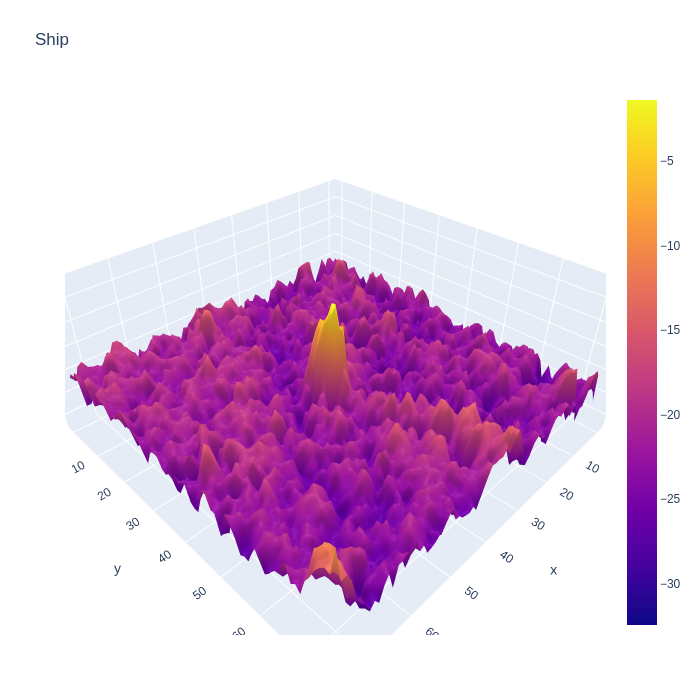

In [8]:
plotmy3d(X_band_1[14, :, :], 'Ship')

- 배는 길쭉한 점처럼 보임. 우리는 배의 모양을 시각화할 수 있는 해상도가 별로 없음. 
- 하지만 CNN이 도와줄 것이고, 선박 빙산 분류에 관한 논문은 거의 없음 : http://elib.dlr.de/99079/2/2016_BENTES_Frost_Velotto_Tings_EUSAR_FP.pdf  
- 그러나 그들의 데이터는 훨씬 더 나은 해상도를 갖기에 나는 그들이 사용한 CNN은 여기에서 적합하지 않다고 생각함.  


- Keras를 사용해 CNN을 만드는 것으로 돌아가자. 다른 것보다 훨씬 더 나은 프레임워크다. 

In [9]:
# Import Keras
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
#from keras.layers.normalization import BatchNormalization
from keras.layers import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

In [10]:
# 모델 정의
def getModel():
  # 모델 작성
  gmodel=Sequential()

  # Conv Layer 1
  gmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(75, 75, 3)))
  gmodel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
  gmodel.add(Dropout(0.2))

  # Conv Layer 2
  gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  gmodel.add(Dropout(0.2))

  # Conv Layer 3
  gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  gmodel.add(Dropout(0.2))

  # Conv Layer 4
  gmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  gmodel.add(Dropout(0.2))

  # Flatten the data for upcoming dense layers
  gmodel.add(Flatten())

  # Dense Layers
  gmodel.add(Dense(512))
  gmodel.add(Activation('relu'))
  gmodel.add(Dropout(0.2))

  # Dense Layer 2
  gmodel.add(Dense(256))
  gmodel.add(Activation('relu'))
  gmodel.add(Dropout(0.2))

  # Sigmoid Layer
  gmodel.add(Dense(1))
  gmodel.add(Activation('sigmoid'))

  myoptim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
  gmodel.compile(loss='binary_crossentropy',
                 optimizer=myoptim,
                 metrics=['accuracy'])
  gmodel.summary()
  return gmodel

def get_callbacks(filepath, patience=2):
  es = EarlyStopping('val_loss', patience=patience, mode="min")
  msave = ModelCheckpoint(filepath, save_best_only=True)
  return [es, msave]
file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

In [11]:
target_train=train['is_iceberg']
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, random_state=1, train_size=0.75)

In [12]:
# 노이즈 제거 없이 핵심 features.
import os
gmodel=getModel()
gmodel.fit(X_train_cv, y_train_cv,
           batch_size=24,
           epochs=50,
           verbose=1,
           validation_data=(X_valid, y_valid),
           callbacks=callbacks)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 36, 36, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 17, 17, 128)       0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Epoch 1/50
51/51 [==============================] - 11s 17ms/step - loss: 0.9693 - accuracy: 0.5902 - val_loss: 0.5929 - val_accuracy: 0.6584
Epoch 2/50
51/51 [==============================] - 1s 11ms/step - loss: 0.5846 - accuracy: 0.6492 - val_loss: 0.5661 - val_accuracy: 0.6733
Epoch 3/50
51/51 [==============================] - 0s 10ms/step - loss: 0.5671 - accuracy: 0.6617 - val_loss: 0.5928 - val_accuracy: 0.6733
Epoch 4/50
51/51 [==============================] - 1s 11ms/step - loss: 0.5590 - accuracy: 0.6633 - val_loss: 0.5495 - val_accuracy: 0.6883
Epoch 5/50
51/51 [==============================] - 1s 11ms/step - loss: 0.5483 - accuracy: 0.6866 - val_loss: 0.5339 - val_accuracy: 0.7082
Epoch 6/50
51/51 [==============================] - 1s 10ms/step - loss: 0.5432 - accuracy: 0.6866 - val_loss: 0.5367 - val_accuracy: 0.7032
Epoch 7/50
51/51 [==============================] - 1s 11ms/step - loss: 0.5452 - accuracy: 0.6808 - val_loss: 0.5175 - val_accuracy: 0.7132
Epoch 8/50
5

- 여기서 점수는 다를 수 있지만 LB에서는 잘 먹혀 0.210점이다. 

In [13]:
gmodel.load_weights(filepath=file_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test Accuracy:', score[1])

13/13 [==============================] - 0s 5ms/step - loss: 0.3236 - accuracy: 0.8454
Test loss: 0.3235686719417572
Test Accuracy: 0.8453865051269531


In [14]:
X_band_test_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test['band_1']])
X_band_test_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test['band_2']])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis], 
                         X_band_test_2[:, :, :, np.newaxis],
                         ((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)
predicted_test = gmodel.predict(X_test)

In [15]:
#submission = pd.DataFrame()
#submission['id']=test['id']
#submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
#submission.to_csv('sub.csv', index=False)

### 결론
- 점수를 올리기 위해 Speckle 필터링, Indicence angle 정규화 등의 전처리를 시도했지만 효과가 없는 것 같음. 
- 시도해 볼 순 있지만, 좋은 결과를 주지 못하고 있음. 
- 이 커널을 사용하면 top-10에 들 수 없기 때문에, 여기 아름다운 정보가 있음. 
- 테스트 데이터 세트에는 8000개의 이미지가 포함되어 있음. 이것을 이용할 수 있음. 우리는 예측을 늘리기 위해 라벨을 붙일 수 있음. 